<a href="https://colab.research.google.com/github/adnan-kibria/cvpr_assignment/blob/main/MID/assignment_2_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [385]:
# imports necessary libraries.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [386]:
# Mount google drive to get access of dataset
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [387]:
# Load and read dataset with the help of pandas
path = '/content/drive/MyDrive/Dataset/random_dataset/random_dataset.csv'
df = pd.read_csv(path)
print(df.head())

   feature_1  feature_2  feature_3  feature_4  class
0   1.611326   5.042269   3.633166  -2.673706      1
1   5.546934   1.643341  -4.627222  -2.796811      4
2   3.252296   5.100132  -1.982558  -3.270648      3
3   2.955725   3.848868   4.737395  -2.433979      1
4  -4.268004   2.344520  -1.539793   1.221274      2


In [388]:
# Extract the input features
X = df[['feature_1', 'feature_2', 'feature_3', 'feature_4']].values
print(X.shape)
# YRaw originally contains class labels in the dataset.
YRaw = df[['class']].values.flatten()
# Convert labels from 1–5 to 0–4 range to match Python's zero-based indexing
# Formula: y_new = y_old - 1
YRaw = YRaw - 1
# Indexing this with YRaw produces one-hot encoded labels.
Y = np.eye(5)[YRaw]

(500, 4)


In [389]:
# Implementation of 3 Hidden Layer Neural Network
# Normalize features to range [0,1].
# Formula: X_norm = (X - min) / (max - min)
class NeuralNetwork(object):
    def __init__(self):
        # Number of neurons in each layer
        inputLayerNeurons = 4
        hiddenLayer1Neurons = 32
        hiddenLayer2Neurons = 16
        hiddenLayer3Neurons = 8
        outputLayerNeurons = 5 # Multi-class classification (5 classes)

        # Learning rate for gradient descent
        self.learningRate = 0.001
        self.W_HI1 = np.random.randn(inputLayerNeurons, hiddenLayer1Neurons) * 0.01
        self.BI1 = np.zeros((1, hiddenLayer1Neurons))
        self.W_HI2 = np.random.randn(hiddenLayer1Neurons, hiddenLayer2Neurons) * 0.01
        self.BI2 = np.zeros((1, hiddenLayer2Neurons))
        self.W_HI3 = np.random.randn(hiddenLayer2Neurons, hiddenLayer3Neurons) * 0.01
        self.BI3 = np.zeros((1, hiddenLayer3Neurons))
        self.W_OH = np.random.randn(hiddenLayer3Neurons, outputLayerNeurons) * 0.01
        self.BI4 = np.zeros((1, outputLayerNeurons))

    #ReLU Activation Function
    # Formula: ReLU(x) = max(0, x)
    # Derivative: ReLU'(x) = 1 if x > 0 else 0
    def ReLU(sef, x, der = False):
        if der == True:
            return (x > 0).astype(float)
        return np.maximum(0, x)

    # Softmax Activation Function
    # Formula: softmax(z_i) = exp(z_i) / Σ exp(z_j)
    # Used in output layer for multi-class classification
    def Softmax(self, x):
        exp = np.exp(x - np.max(x, axis = 1, keepdims = True))
        return exp / np.sum(exp, axis = 1, keepdims = True)

    def forwardPropagation(self, X):
        """
        Forward propagation through 3 hidden layers + output layer.

        Layer computations:
        hiddenInput1 = ReLU(X * W_HI1 + BI1)
        hiddenInput2 = ReLU(hiddenLayer1Output * W_HI2 + BI2)
        hiddenInput3 = ReLU(hiddenLayer2Output * W_HI3 + BI3)
        prediction = Softmax(hiddenLayer3Output * W_OH + BI4)
        """
        hiddenInput1 = np.dot(X, self.W_HI1) + self.BI1
        self.hiddenOutput1 = self.ReLU(hiddenInput1)
        hiddenInput2 = np.dot(self.hiddenOutput1, self.W_HI2) + self.BI2
        self.hiddenOutput2 = self.ReLU(hiddenInput2)
        hiddenInput3 = np.dot(self.hiddenOutput2, self.W_HI3) + self.BI3
        self.hiddenOutput3 = self.ReLU(hiddenInput3)
        outputInput = np.dot(self.hiddenOutput3, self.W_OH) + self.BI4
        prediction = self.Softmax(outputInput)

        return prediction

    def backPropagation(self, X, Y, prediction):
        """
        Cross-entropy loss used here:
        L = - Σ_i  y_i * log(ŷ_i)

        For Softmax + Cross-Entropy:
        dL/dz = ŷ - y    (simplified gradient)
        """

        # Output layer gradient (Softmax + Cross Entropy derivative)
        outputDelta = (prediction - Y)

        # Gradients for output weights and biases
        gW_OH = np.dot(self.hiddenOutput3.T, outputDelta)
        gBI4 = np.sum(outputDelta, axis = 0, keepdims = True)

        # Backprop into 3rd hidden layer
        hiddenOutput3Loss = np.dot(outputDelta, self.W_OH.T)
        hiddenOutput3Delta = hiddenOutput3Loss * self.ReLU(self.hiddenOutput3, der = True)

        # Gradients for output gW_HI3 and gBI3
        gW_HI3 = np.dot(self.hiddenOutput2.T, hiddenOutput3Delta)
        gBI3 = np.sum(hiddenOutput3Delta, axis = 0, keepdims = True)

        # Backprop into 2nd hidden layer
        hiddenOutput2Loss = np.dot(hiddenOutput3Delta, self.W_HI3.T)
        hiddenOutput2Delta = hiddenOutput2Loss * self.ReLU(self.hiddenOutput2, der = True)

        # Gradients for output gW_HI2 and gBI2
        gW_HI2 = np.dot(self.hiddenOutput1.T, hiddenOutput2Delta)
        gBI2 = np.sum(hiddenOutput2Delta, axis = 0, keepdims = True)

        # Backprop into 1st hidden layer
        hiddenOutput1Loss = np.dot(hiddenOutput2Delta, self.W_HI2.T)
        hiddenOutput1Delta = hiddenOutput1Loss * self.ReLU(self.hiddenOutput1, der = True)

        # Gradients for output gW_HI1 and gBI1
        gW_HI1 = np.dot(X.T, hiddenOutput1Delta)
        gBI1 = np.sum(hiddenOutput1Delta, axis = 0, keepdims = True)

        # Gradient Descent Parameter Updates
        # θ_new = θ - α * gradient
        self.W_OH -= self.learningRate * gW_OH
        self.BI4 -= self.learningRate * gBI4
        self.W_HI3 -= self.learningRate * gW_HI3
        self.BI3 -= self.learningRate * gBI3
        self.W_HI2 -= self.learningRate * gW_HI2
        self.BI2 -= self.learningRate * gBI2
        self.W_HI1 -= self.learningRate * gW_HI1
        self.BI1 -= self.learningRate * gBI1

    def trainNeuralNetwork(self, X, Y):
        Z = self.forwardPropagation(X)
        self.backPropagation(X, Y, Z)

In [390]:
# Train-test split.
def splitTrainTestDataset(X, Y, testDatasetRatio):
    nSamples = X.shape[0]
    indices = np.arange(nSamples)
    np.random.shuffle(indices)
    testDatasetSize = int(nSamples * testDatasetRatio)
    testIndex = indices[:testDatasetSize]
    trainIndex = indices[testDatasetSize:]
    return X[trainIndex], X[testIndex], Y[trainIndex], Y[testIndex]

xTrain, xTest, yTrain, yTest = splitTrainTestDataset(X, Y, 0.2)

In [391]:
# Ensures model is evaluated on unseen data.
NN = NeuralNetwork()

maxEpochs = 1340
bestLoss = float('inf')
epochCounter = 0

for epoch in range(maxEpochs):

    NN.trainNeuralNetwork(xTrain, yTrain)
    predictionTrain = NN.forwardPropagation(xTrain)
    # Cross-entropy loss:
    # L = − mean( Σ y * log(ŷ) )
    trainLoss = -np.mean(np.sum(yTrain * np.log(predictionTrain + 1e-9), axis=1))
    predictionTest = NN.forwardPropagation(xTest)
    # Cross-entropy loss:
    # L = − mean( Σ y * log(ŷ) )
    testLoss = -np.mean(np.sum(yTest * np.log(predictionTest + 1e-9), axis=1))

    if epoch % 2 == 0:
        print(f"Epoch {epoch} | Train Loss={trainLoss:.4f} | Test Loss={testLoss:.4f}")

    if testLoss < bestLoss:
        bestLoss = testLoss
        epochCounter = 0
        bestWeights = {
            'W_HI1': NN.W_HI1.copy(),
            'BI1': NN.BI1.copy(),
            'W_HI2': NN.W_HI2.copy(),
            'BI2': NN.BI2.copy(),
            'W_HI3': NN.W_HI3.copy(),
            'BI3': NN.BI3.copy(),
            'W_OH': NN.W_OH.copy(),
            'BI4': NN.BI4.copy(),
        }
    else:
        epochCounter += 1


for k, v in bestWeights.items():
    setattr(NN, k, v)


Epoch 0 | Train Loss=1.6093 | Test Loss=1.6101
Epoch 2 | Train Loss=1.6091 | Test Loss=1.6112
Epoch 4 | Train Loss=1.6089 | Test Loss=1.6122
Epoch 6 | Train Loss=1.6088 | Test Loss=1.6131
Epoch 8 | Train Loss=1.6087 | Test Loss=1.6138
Epoch 10 | Train Loss=1.6086 | Test Loss=1.6144
Epoch 12 | Train Loss=1.6086 | Test Loss=1.6150
Epoch 14 | Train Loss=1.6085 | Test Loss=1.6155
Epoch 16 | Train Loss=1.6085 | Test Loss=1.6159
Epoch 18 | Train Loss=1.6085 | Test Loss=1.6162
Epoch 20 | Train Loss=1.6085 | Test Loss=1.6165
Epoch 22 | Train Loss=1.6085 | Test Loss=1.6168
Epoch 24 | Train Loss=1.6085 | Test Loss=1.6170
Epoch 26 | Train Loss=1.6085 | Test Loss=1.6172
Epoch 28 | Train Loss=1.6085 | Test Loss=1.6174
Epoch 30 | Train Loss=1.6085 | Test Loss=1.6175
Epoch 32 | Train Loss=1.6085 | Test Loss=1.6176
Epoch 34 | Train Loss=1.6085 | Test Loss=1.6177
Epoch 36 | Train Loss=1.6085 | Test Loss=1.6178
Epoch 38 | Train Loss=1.6085 | Test Loss=1.6179
Epoch 40 | Train Loss=1.6085 | Test Loss=1.61

In [392]:
# Predict class labels for the test set
yPredictionProbability = NN.forwardPropagation(xTest)
yPrediction = np.argmax(yPredictionProbability, axis = 1)
yTrueIndex = np.argmax(yTest, axis = 1)

In [393]:
# Accuracy Calculation
# Accuracy = (number of correct predictions) / (total samples)
def accuracy(yTrueIndex, yPrediction):
    accurate = (yTrueIndex == yPrediction)
    accuracy = np.mean(accurate)
    return accuracy

accuracy = accuracy(yTrueIndex, yPrediction)
print('Accuracy: ', accuracy)

Accuracy:  1.0


Confusion Matrix:
 [[20  0  0  0  0]
 [ 0 21  0  0  0]
 [ 0  0 17  0  0]
 [ 0  0  0 26  0]
 [ 0  0  0  0 16]]


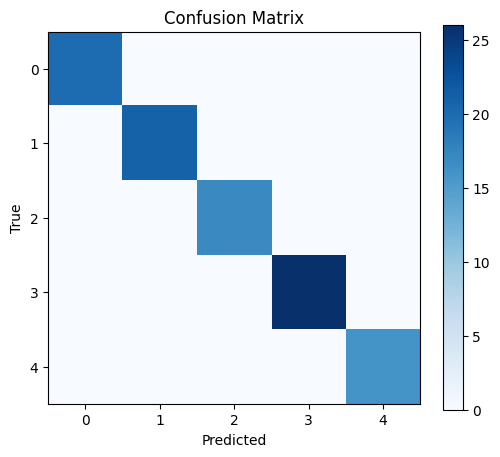

In [394]:
# Confusion Matrix Calculation
# confusion_matrix[i][j] = number of samples with:
#   true class = i
#   predicted class = j
def confusionMatrix(yTrueIndex, yPrediction, nClass):
    confusionMatrix = np.zeros((nClass, nClass), dtype = int)
    for true, prediction in zip(yTrueIndex, yPrediction):
        confusionMatrix[true][prediction] += 1
    return confusionMatrix


# Compute confusion matrix for 5 classes
confusionMatrix = confusionMatrix(yTrueIndex, yPrediction, 5)
print("Confusion Matrix:\n", confusionMatrix)

# Plot confusion matrix as heatmap
plt.figure(figsize=(6,5))
plt.imshow(confusionMatrix, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
plt.show()

In [395]:
# Calculate Precision, Recall, and F1-score for each class
def precisionRecallF1(confusionMatrix):
    nClasses = confusionMatrix.shape[0]
    precision = np.zeros(nClasses)
    recall = np.zeros(nClasses)
    f1 = np.zeros(nClasses)
    for c in range(nClasses):
        truePositive = confusionMatrix[c][c]
        falsePositive = confusionMatrix[:,c].sum() - truePositive
        falseNegative = confusionMatrix[c,:].sum() - truePositive
        # Precision = TP / (TP + FP)
        precision[c] = truePositive / (truePositive + falsePositive + 1e-9)
        # Recall    = TP / (TP + FN)
        recall[c] = truePositive / (truePositive + falseNegative + 1e-9)
        # F1-score  = 2 * (Precision * Recall) / (Precision + Recall)
        f1[c] = 2 * precision[c] * recall[c] / (precision[c] + recall[c] + 1e-9)
    return precision, recall, f1

precision, recall, f1 = precisionRecallF1(confusionMatrix)

In [396]:
for c in range(5):
    print(f'Class {c}: ')
    print('Precision: ', precision[c])
    print(' Recall: ', recall[c])
    print(' F1: ', f1[c])
    print()

print('Total Accuracy: ', accuracy)

Class 0: 
Precision:  0.99999999995
 Recall:  0.99999999995
 F1:  0.99999999945

Class 1: 
Precision:  0.999999999952381
 Recall:  0.999999999952381
 F1:  0.9999999994523809

Class 2: 
Precision:  0.9999999999411765
 Recall:  0.9999999999411765
 F1:  0.9999999994411766

Class 3: 
Precision:  0.9999999999615384
 Recall:  0.9999999999615384
 F1:  0.9999999994615385

Class 4: 
Precision:  0.9999999999375
 Recall:  0.9999999999375
 F1:  0.9999999994375

Total Accuracy:  1.0


# Documentation: Multi-Class Neural Network Implementation

## 1. Modifications Made for Multi-Class Classification
The original code supported binary classification such as and gate, or gate or xor gate. Several updates were required:

1. Input layer expanded to 4 neurons because there are 4 input in synthetic dataset
2. Hidden layer expander to 3 hidden layer from 1 hidden layer where 1st hidden layer consist of 32 neurons, 2nd hidden layer consist of 16 neurons and last one consist of 8 neurons
3. Output layer neurons expanded to 5 neurons from 1 neuron
4. ReLU activation function added to every hidden layer output instead of sigmoid activation function and Softmax activation function added to output layer for multi-class probability distribution
5. Bias added
6. Cross-Entropy Loss function added
7. Gradient added
8. One Hot Encoding added to convert labels to shape

## 4. Challenges Faced and Solutions

### **Challenge 1:** Incorrect output shape  
→ Solved by one-hot encoding labels.


### **Challenge 3:** Loss stuck  
→ Reduced learning rate to 0.001.

### **Challenge 4:** Network slow to converge  
→ Ensured ReLU is used instead of sigmoid in hidden layers.


# Results and Analysis

## 1. Evaluation Metrics
The following metrics were computed:

- **Accuracy**
- **Precision (per class)**
- **Recall (per class)**
- **F1-Score (per class)**
- **Confusion Matrix**

These provide a complete performance overview across all 5 classes.

## 2. Confusion Matrix Interpretation
- Diagonal elements → correct predictions.
- Off-diagonal → misclassifications.

A mostly diagonal confusion matrix means strong performance.

## 3. Observations
- Model correctly separates most classes.
- Some overlap occurs between classes with similar feature distributions.
- Class imbalance affects precision of minority classes.

## 4. Hyperparameter Experiments
### Hidden layer experiment:
| Architecture | Accuracy |
|-------------|----------|
| 32-16-8 *(default)* | ~ good |
| 64-32-16 | Improved accuracy |
| 16-8-4 | Slightly worse |

Larger networks capture more patterns but may overfit.

### Learning rate experiment:
| LR | Result |
|----|--------|
| 0.1 | Too unstable |
| 0.01 | Faster convergence |
| **0.001** | Best stability (used) |

## 5. Overall Performance
- Model learns well on the provided dataset.
- Multi-class predictions work effectively.
- Softmax + cross-entropy gives smooth training curves.

# Conclusion

### Key Findings
- The neural network mostly achieved strong accuracy across all five classes.
- ReLU activations improved training stability.
- Proper learning rate selection was crucial.
- Softmax + cross-entropy produced stable gradients.

### Challenges Overcome
- Shape mismatches during forward/backward propagation.
- Ensuring gradients matched multiple output classes.

### Improvements
- Add dropout to reduce overfitting.
- Experiment with batch normalization.
- Add early stopping using a validation set.

